In [1]:
import bambi as bmb
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import numpy as np

In [2]:
chimps = pd.read_csv('./data/chimpanzees.csv', sep=';')
chimps['treatment'] = 1 + chimps['prosoc_left'] + 2*chimps['condition']

In [3]:
chimps

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2
...,...,...,...,...,...,...,...,...,...
499,7,4.0,1,6,64,1,1,1,4
500,7,6.0,1,6,66,1,1,1,4
501,7,3.0,1,6,68,0,0,1,3
502,7,7.0,1,6,70,0,0,1,3


In [4]:
chimps.isna().sum()

actor             0
recipient       252
condition         0
block             0
trial             0
prosoc_left       0
chose_prosoc      0
pulled_left       0
treatment         0
dtype: int64

In [5]:
model = bmb.Model(
    "pulled_left ~ 0 + (1|actor) + (1|treatment)", 
    family='bernoulli',
    data=chimps
    )

idata = model.fit(inference_method='nuts_blackjax')

Modeling the probability that pulled_left==1
/Users/gabestechschulte/miniforge3/envs/bambi/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...
Compilation time =  0:00:01.520333
Sampling...
Sampling time =  0:00:03.043604
Transforming variables...
Transformation time =  0:00:00.616552


In [6]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|actor_sigma,2.272,0.816,1.005,3.809,0.033,0.023,546.0,1457.0,1.01
1|treatment_sigma,0.716,0.490,0.080,1.562,0.025,0.021,587.0,553.0,1.00
1|actor[1],-0.500,0.426,-1.306,0.285,0.015,0.012,839.0,916.0,1.01
1|actor[2],4.677,1.484,2.495,7.564,0.042,0.030,1014.0,2025.0,1.01
1|actor[3],-0.803,0.430,-1.715,-0.092,0.016,0.012,827.0,971.0,1.01
1|actor[4],-0.795,0.427,-1.688,-0.081,0.016,0.012,805.0,687.0,1.01
1|actor[5],-0.503,0.425,-1.327,0.303,0.016,0.012,792.0,833.0,1.01
1|actor[6],0.441,0.422,-0.323,1.271,0.015,0.011,807.0,857.0,1.01
1|actor[7],1.966,0.511,1.022,2.914,0.016,0.011,1023.0,926.0,1.00
1|treatment[1],0.002,0.386,-0.678,0.815,0.015,0.010,734.0,814.0,1.01


In [7]:
# number of divergences
idata['sample_stats']['diverging'].to_numpy().sum()

3

### Prior Predictive

In [8]:
prior_pred = model.prior_predictive()

Sampling: [1|actor_offset, 1|actor_sigma, 1|treatment_offset, 1|treatment_sigma, pulled_left]


In [9]:
prior_probs = prior_pred['prior_predictive']['pulled_left'].to_numpy()

In [10]:
# get proportion of 1s to total in a...
prior_prop = prior_probs[0].sum(axis=0) / prior_probs[0].sum(axis=0).shape

In [ ]:
sns.kdeplot(prior_prop, clip=[0, 1])

### Posterior

In [126]:
idata['posterior']['1|actor'].to_numpy().shape

(4, 1000, 7)

In [12]:
p_left = np.array(jax.scipy.special.expit(idata['posterior']['1|actor'].to_numpy()[0]))
p_left.shape

(1000, 7)

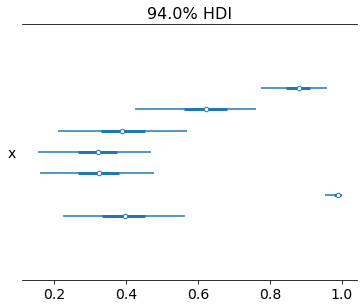

In [13]:
az.plot_forest(p_left.T);

In [14]:
idata['posterior']['1|actor'].to_numpy()[0]

array([[-0.32737262,  5.13921635, -0.94370424, ..., -0.23823081,
         0.52931897,  1.70357938],
       [-0.45404655,  3.40484189, -0.8371948 , ..., -0.57717194,
         0.49872315,  1.76190132],
       [-0.17967329,  3.54284028, -0.91471999, ..., -0.74806773,
         0.53379141,  2.50079995],
       ...,
       [-0.15159774,  5.25662653, -0.84148458, ..., -0.7738798 ,
         0.17360727,  2.35710025],
       [-0.57295983,  5.17443557, -0.93018268, ..., -0.89418183,
         0.3367844 ,  2.83093392],
       [-0.71826282,  2.83540058, -0.75010922, ..., -0.12094109,
         0.49699224,  1.60249543]])

### Accessing back-end objects

In [156]:
type(model.backend.model), model.backend.model

(pymc.model.Model,
      1|actor_sigma ~ N**+(0, 2.5)
     1|actor_offset ~ N(0, 1)
  1|treatment_sigma ~ N**+(0, 2.5)
 1|treatment_offset ~ N(0, 1)
            1|actor ~ Deterministic(f(1|actor_offset, 1|actor_sigma))
        1|treatment ~ Deterministic(f(1|treatment_offset, 1|treatment_sigma))
        pulled_left ~ Bern(f(1|treatment_offset, 1|treatment_sigma, 1|actor_offset, 1|actor_sigma)))

### Hierarchical Model

In [149]:
chimps.tail()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
499,7,4.0,1,6,64,1,1,1,4
500,7,6.0,1,6,66,1,1,1,4
501,7,3.0,1,6,68,0,0,1,3
502,7,7.0,1,6,70,0,0,1,3
503,7,2.0,1,6,72,0,0,1,3


In [15]:
hier_model = bmb.Model(
    "pulled_left ~ 0 + (1|actor) + (1|block) + (1|treatment)", 
    family='bernoulli',
    data=chimps
    )

model.build()

In [16]:
idata = hier_model.fit(inference_method='nuts_blackjax')

Modeling the probability that pulled_left==1


Compiling...
Compilation time =  0:00:01.046737
Sampling...
Sampling time =  0:00:03.792995
Transforming variables...
Transformation time =  0:00:00.846250


In [17]:
idata['sample_stats']['diverging'].to_numpy().sum()

3

In [18]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|actor_sigma,2.304,0.765,1.160,3.828,0.025,0.018,865.0,1667.0,1.00
1|block_sigma,0.233,0.191,0.000,0.572,0.005,0.004,1152.0,1180.0,1.00
1|treatment_sigma,0.702,0.463,0.110,1.573,0.018,0.013,685.0,1198.0,1.01
1|actor[1],-0.504,0.441,-1.322,0.363,0.019,0.014,582.0,682.0,1.01
1|actor[2],4.722,1.410,2.470,7.372,0.033,0.023,1682.0,1372.0,1.00
1|actor[3],-0.804,0.446,-1.672,0.041,0.018,0.014,630.0,631.0,1.01
1|actor[4],-0.800,0.442,-1.628,0.069,0.018,0.014,602.0,602.0,1.01
1|actor[5],-0.492,0.434,-1.385,0.272,0.019,0.019,590.0,527.0,1.01
1|actor[6],0.444,0.444,-0.446,1.258,0.018,0.013,616.0,657.0,1.01
1|actor[7],1.985,0.516,1.087,3.066,0.018,0.012,880.0,1004.0,1.01


In [26]:
actor_sigma = idata['posterior']['1|actor_sigma'].to_numpy()
block_sigma = idata['posterior']['1|block_sigma'].to_numpy()

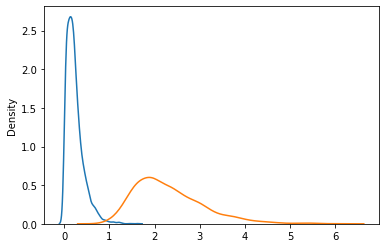

In [34]:
sns.kdeplot(block_sigma.flatten())
sns.kdeplot(actor_sigma.flatten());